# Intro


This is the notebook done by Perrine Woringer, Roberto Ceraolo and Roberto Minini for the project of the LPBS at EPFL University towards the study of generation of realistic deformations of C. Elegans images through GANs. The final report of the project is available [here](https://drive.google.com/file/d/1eIDcZ5Il8jAKw0gIQpeoPpvICfUvIm-k/view?usp=sharing) (an EPFL account is needed). The procedure of this notebook replicates what was done by Stephens et al. in their paper _Dimensionality and Dynamics in the Behavior of C. elegans_. The goal we are using the procedure for is to be able to compare the distributions of the shapes of the worms between the real data and the images generated by the GAN. For details about the rationale of the procedure please refer to the paper. 

The main steps of the procedure are the following:
1. Preprocessing on images
2. Extracting the [morphological skeleton](https://en.wikipedia.org/wiki/Morphological_skeleton) of the worms  and pruning if necessary
3. Finding the "chain" - the list of pixels composing the skeletons
4. Interpolating the chains to find the splines representing the shapes of the worms
5. Taking the angles between 100 points of the splines with the horizontal direction (to characterize numerically the curve). This way a matrix of angles is obtained. 
6. Applying PCA to the covariance matrix of such matrix, in order to obtain the _eigenworms_, i.e. the principal components. The first 4 principal components are able to explain over 95% of variance.
7. Finally, plotting the first 2 and 3 principal components. 

We applied such procedure both to real and to generated images, in order to compare the two distributions.

To use this code, it suffices to replace the path of the images and run all cells. In most steps, there are sanity checks or plots in order to verify that everything is working correctly. 

We are open to answer any doubt or receive feedbacks and suggestions, please write an email to:
roberto.ceraolo@epfl.ch or roberto.minini@epfl.ch

# Imports

We import the necessary libraries. Plantcv is used to do operations on the morphological skeleton.

In [1]:
%matplotlib inline

In [130]:
from skimage.morphology import skeletonize, medial_axis, binary_opening, disk
import matplotlib.pyplot as plt
import os
from skimage import io
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.util import crop
import numpy as np
from math import sqrt
from scipy import interpolate
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D 
from plantcv import plantcv as pcv
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import disk 

# Image preprocessing


We first upload the pictures and apply some preprocessing.

In [132]:
%%time

path = "full_128-ryu_run01-auto1-resumecustom/"

list_files = os.listdir(path)
image_list = []
for filename in list_files:
    if filename.endswith(".png"):
        image_list.append(io.imread(path+filename))

Wall time: 11.3 s


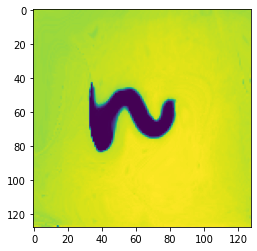

In [133]:
plt.imshow(image_list[0])

In [ ]:
len(image_list) #sanity check

## Binarization (dark content, light background)

Now the images get binarized, to make the skeleton extraction procedure easier.

In [135]:
%%time

for i in range(len(image_list)):
    image_list[i] = image_list[i] < threshold_otsu(image_list[i])

Wall time: 1.58 s


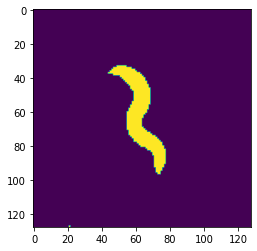

In [136]:
plt.imshow(image_list[19])

## Crop around largest connected component

The images get cropped around the largest connected component, which is clearly the body of the worm, as we don't need the background.

In [137]:
%%time

for i in range(len(image_list)):
    regions = label(image_list[i])
    max_area = 0
    for region in regionprops(regions):
        if region.area > max_area:
            max_area = region.area
            image_list[i] = region.image

Wall time: 2.81 s


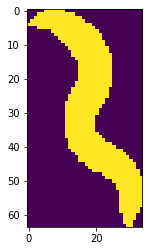

In [138]:
plt.imshow((image_list[19]))

# Skeletonization procedure

The following is the procedure to extract the morphological skeleton of the images. In some cases, the skeletons have small undesired outgoing branches. In those cases we apply "pruning" in order to have curves which can later be interpolated with a spline.

In [140]:
%%time
#Functional version of the procedure a few cells above
def crop_around_largest_conn_component(image):
    regions = label(image)
    max_area = 0
    for region in regionprops(regions):
        if region.area > max_area:
            max_area = region.area
            image = region.image
   # plt.imshow(image)
    #plt.show()
    return image

Wall time: 0 ns


In [141]:
#Function to remove the shortest of the segments composing the skeleton
def remove_shortest(segment_objects, shortest):
    for ind, element in enumerate(segment_objects):
        if len(element) == len(shortest):
            if np.all(element.flatten() == shortest.flatten()):
                ind_to_remove = ind
    segment_objects.pop(ind_to_remove)
    return segment_objects
            

In [142]:
%%time

# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "None"


def manual_skeleton(img, plotting, debug = False):
"""
This function extracts the skeleton using plantcv. If small branches (shorter than 80 pixels) are present,
the plantcv pruning is applied. If some other branches are still present, they get removed afterwards.
"""

    skeleton = pcv.morphology.skeletonize(mask=img) #skeleton extraction

    pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skel_img=skeleton, size=80) #plantcv pruning

    shortest = min(segment_objects, key=len)
    
    if debug: 
        el_to_ret = (segment_objects, shortest)
        return el_to_ret
    
    #ind = segment_objects.index(shortest)
    segment_objects = remove_shortest(segment_objects, shortest)
    
    manually_pruned = pruned_skeleton.copy()
    
    
    
    while len(segment_objects) >1: #Manual removal of other branches, only if still present after plantcv pruning 
        xs=[]
        ys = []
        for el in shortest:
            xs.append(el.flatten()[1])
            ys.append(el.flatten()[0])


        for i in range(len(xs)):
            manually_pruned[xs[i], ys[i]] = 0 #setting to 0 the pixels of the branch
        
        shortest = min(segment_objects, key=len) #find the new shortest
        segment_objects = remove_shortest(segment_objects, shortest) #remove the new shortest

#        
    cropped = crop_around_largest_conn_component(manually_pruned) #we crop again around the largest connected component
    if plotting:
        print("Cropped")
        plt.imshow(cropped)
        plt.show()
    skeleton = pcv.morphology.skeletonize(mask=cropped)#final skeleton extraction 
    return skeleton

Wall time: 1 ms


In [143]:
#Computing the pruned skeleton for every image
footprint = disk(2)
skeleton_list = []
plotting = False
for i in range(len(image_list)):
    print(f"Image {i}")
    img = image_list[i].astype(int)
    img_closed = closing(img,footprint) #we apply morphological closing
    if plotting:
        plt.imshow(img)
        plt.show()
        print("Closed image")
        plt.imshow(img_closed)
        plt.show()
    skeleton_list.append(manual_skeleton(img_closed, plotting=plotting))
    
    
#This was the old skeletoniztion procedure, that had some issues, kept for reference:
#skeleton_list = [skeletonize(binary_opening(image,disk(radius=1))) for image in image_list]

Image 0
Image 1
Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9
Image 10
Image 11
Image 12
Image 13
Image 14
Image 15
Image 16
Image 17
Image 18
Image 19
Image 20
Image 21
Image 22
Image 23
Image 24
Image 25
Image 26
Image 27
Image 28
Image 29
Image 30
Image 31
Image 32
Image 33
Image 34
Image 35
Image 36
Image 37
Image 38
Image 39
Image 40
Image 41
Image 42
Image 43
Image 44
Image 45
Image 46
Image 47
Image 48
Image 49
Image 50
Image 51
Image 52
Image 53
Image 54
Image 55
Image 56
Image 57
Image 58
Image 59
Image 60
Image 61
Image 62
Image 63
Image 64
Image 65
Image 66
Image 67
Image 68
Image 69
Image 70
Image 71
Image 72
Image 73
Image 74
Image 75
Image 76
Image 77
Image 78
Image 79
Image 80
Image 81
Image 82
Image 83
Image 84
Image 85
Image 86
Image 87
Image 88
Image 89
Image 90
Image 91
Image 92
Image 93
Image 94
Image 95
Image 96
Image 97
Image 98
Image 99
Image 100
Image 101
Image 102
Image 103
Image 104
Image 105
Image 106
Image 107
Image 108
Image 109
Image 110


In [144]:
len(skeleton_list) #Sanity check

7200

We now have a list containing all the skeletons.

### Get list of pixels forming skeleton

The next steps is to find out what pixels are part of the skeleton. To do this we need to find the chains, which are lists of pixels which are all connected and which go from one endpoint to the other.

In [145]:
def find_one_endpoint(skeleton_indices, skeleton_image):
    for x,y in skeleton_indices:
        count_neigbours = 0
        for i in [-1,0,1]:
            if count_neigbours == 2: # if a pixel has 2 neighbours, it is not an endpoint and we break the loop
                break
            for j in [-1,0,1]:
                if count_neigbours == 2: # if a pixel has 2 neighbours it is not an endpoint and we brake the loop
                    break
                if i != 0 or j != 0:
                    try:
                        if skeleton_image[x+i,y+j]>0:
                            count_neigbours += 1
                    except IndexError:
                        pass
        if count_neigbours == 1: # if a pixel has 1 neighbour it is an endpoint
            return x,y # the functions returns the pair of indices which identify the endpoint

In [146]:
def find_neighbour(x,y,skeleton_indices):
    # this function returns one of the nighbours which is in the skeleton_indices
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            if (x+i, y+j) in skeleton_indices:
                return (x+i, y+j)

In [147]:
def find_chain(skeleton_image):
    skeleton_indices = list(zip(*np.where(skeleton_image>0)))
    x_start, y_start = find_one_endpoint(skeleton_indices, skeleton_image)
    chain = [(x_start, y_start)] # we start with the endpoint and we build the chain progressively
    skeleton_indices.remove((x_start, y_start))
    while len(skeleton_indices) > 0:
        x, y = chain[-1]  #we consider the last part of the chain
        x_n, y_n = find_neighbour(x,y,skeleton_indices)
        skeleton_indices.remove((x_n, y_n)) # we remove this pixel so that next time the fucntion find_neighbour will find a different neighbour, if it existss
        chain.append((x_n, y_n))
    return chain

Now we process the skeleton of every image and we store the associated chain. If an error is thrown when analyzing the skeleton of an image, we simply ignore the skeleton of the problematic picture.

In [148]:
%%time

chain_list = []
for skeleton in skeleton_list:
    try:
        chain_list.append(find_chain(skeleton))
    except:
        pass

Wall time: 14.7 s


Now we have a list of chains. Starting from the chains, we will now be able to do an interpolation of the spline and to compute the angles which we will use to characterize the distribution of the shapes of the worms.

### Spline interpolation, compute theta

Now we interpolate the spline of each worm in order to be able to compute the angles of curvature using the arctangent function.

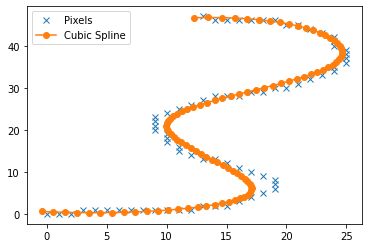

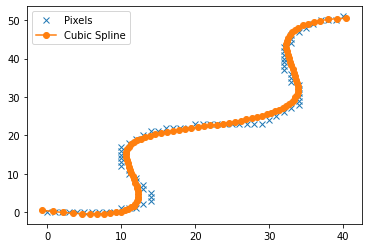

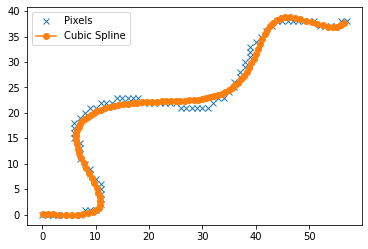

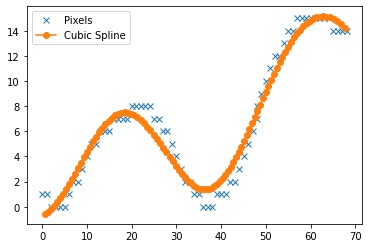

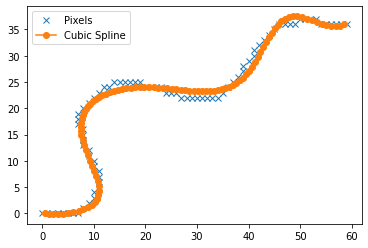

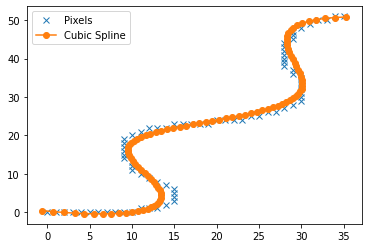

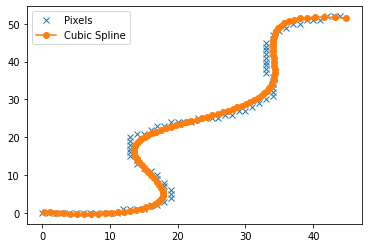

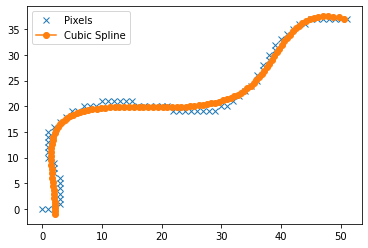

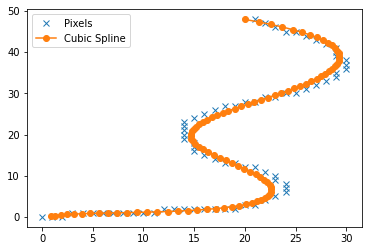

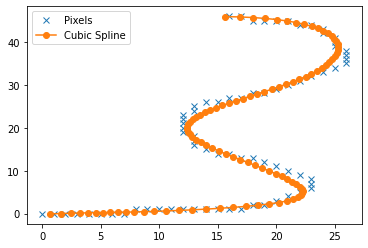

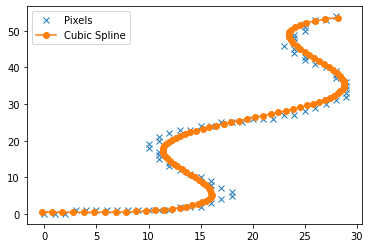

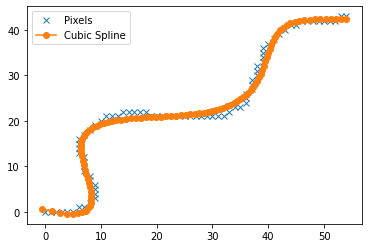

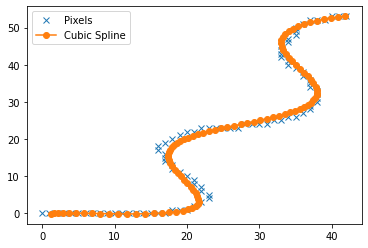

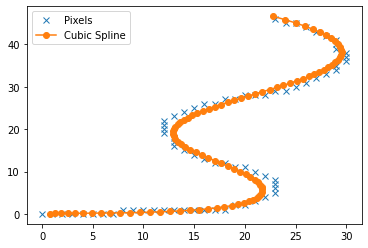

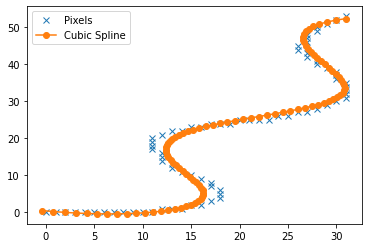

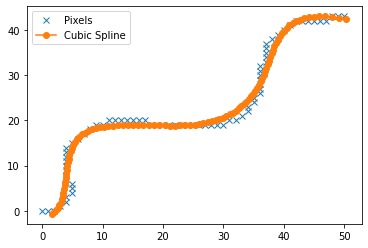

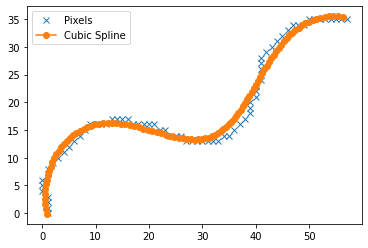

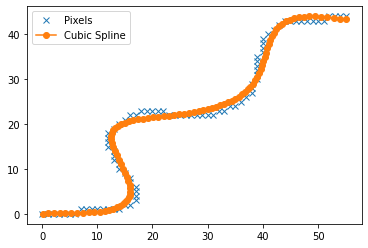

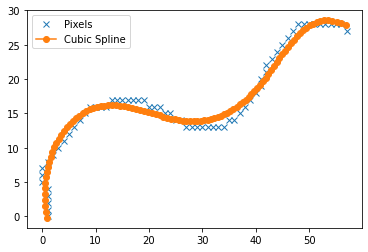

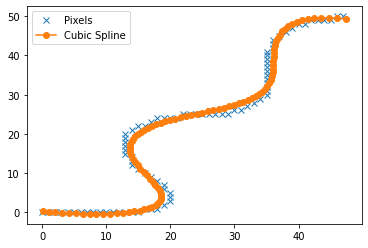

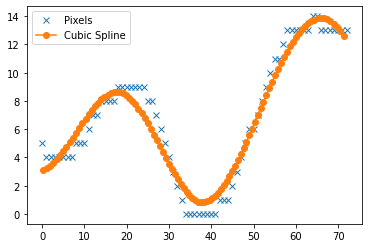

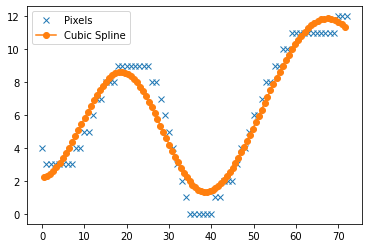

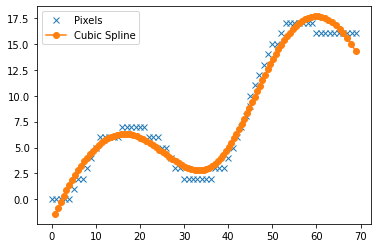

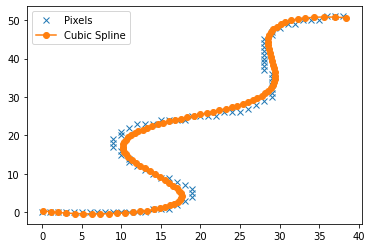

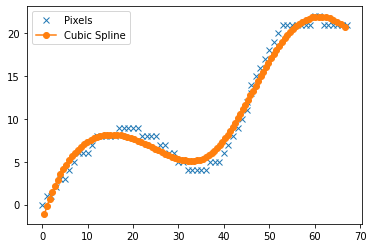

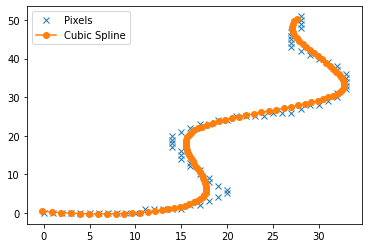

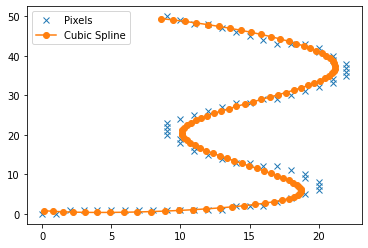

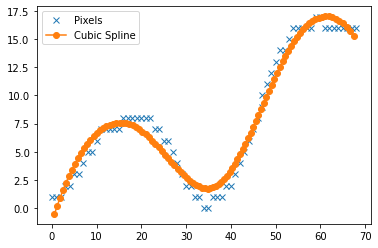

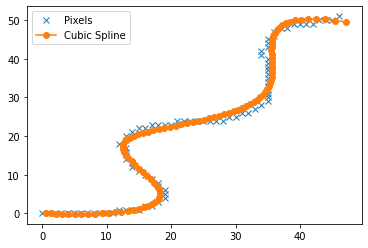

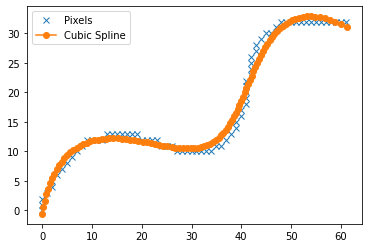

Wall time: 13.3 s


In [153]:
%%time

nbr_points = 100 #this parameter is arbitrary and can be changed. We are using the same number as the referenced paper. 100 points provide enough granularity to characterize the skeleton.

matrix_of_thetas = np.zeros((len(chain_list), nbr_points-2))
k = 30
c = 0 # this is a counter which is used just to plot the top k interpoleted splines. Here we k was set to 30
for n, chain in enumerate(chain_list):
    x = [xy[0] for xy in chain]
    y = [xy[1] for xy in chain]
    cubic_spline, s = interpolate.splprep([x, y])
    delta_s = 1/(nbr_points)
    t = np.arange(delta_s/2, 1.0+delta_s/2, delta_s)
    spline_position = interpolate.splev(t, cubic_spline) # we interpolate using a cubic spline
    x_spline = spline_position[0]
    y_spline = spline_position[1]
    if c < k:
        c +=1
        #plt.figure(figsize=(10,10))
        plt.plot(x, y, "x", x_spline, y_spline, "-o")
        plt.legend(['Pixels', 'Cubic Spline'])
        plt.show()
    
    theta = np.zeros(nbr_points-2)
    for i in range(1,len(t)-1):
        theta[i-1] = np.arctan2((x_spline[i+1]-x_spline[i-1])/2, (y_spline[i+1]-y_spline[i-1])/2)
    theta = np.unwrap(theta)
    theta = theta - np.mean(theta) # we center the thetas in order to have mean equal to 0
    #plt.plot(theta, "-o")
    #plt.show()
    matrix_of_thetas[n] = theta


# Covariance matrix 

We start by computing the covariance matrix, as it's done in the referenced paper.

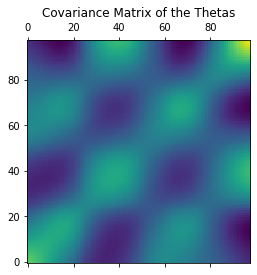

In [154]:
cov = np.cov(matrix_of_thetas.T) # we need to transpose in order not to have, as a covariance matrix, a matrix n x n where n is the number of worm images. What we are instead interested in is a 100 x 100 matrix, where 100 is the number of thetas
plt.matshow(cov)
plt.gca().invert_yaxis() #we invert the axis to get the graph oriented in the same way as in the DBC paper
plt.title("Covariance Matrix of the Thetas")
plt.savefig("graphs_ryu/covariance_matrix.jpg")

# Manually computing PCA

We manually compute PCA so that later we can check that the results are similar to those obtained with the sklearn PCA.

In [155]:
%%time

eigen_values, eigen_vectors = np.linalg.eigh(cov)
eigen_ind_order = np.flip(eigen_values.argsort())
eigen_values = eigen_values[eigen_ind_order]
eigen_vectors = eigen_vectors[:, eigen_ind_order]

Wall time: 18.8 ms


In [157]:
X = matrix_of_thetas

# we calculate eigen values
X_cov = np.cov(X.T)
e_values, e_vectors = np.linalg.eigh(X_cov)

# we sort eigenvalues and their eigenvectors in descending order
e_ind_order = np.flip(e_values.argsort())
e_values = e_values[e_ind_order]
e_vectors = e_vectors[:, e_ind_order] # note that we have to re-order the columns, not rows

# now we can project the dataset on to the eigen vectors (principal axes)
pca_proj = X @ e_vectors

# Variances explained

We compute how much variance is explained by each dimension and we plot it in the following graphs.

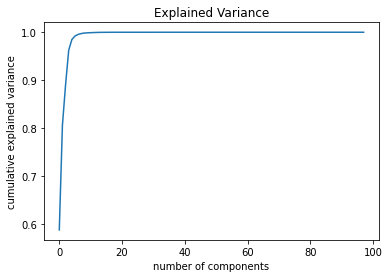

In [158]:
from sklearn.decomposition import PCA

pca = PCA().fit(matrix_of_thetas.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Explained Variance")
plt.savefig("graphs_ryu/explained_variance.jpg")

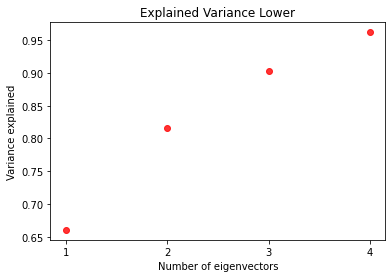

In [159]:
#Alternative way of showing the figures, with only the first four eigenvectors

for i in range(1, len(variance_explained)):
    variances = np.cumsum(variance_explained)
    x = np.arange(1,5)
plt.scatter(x, variances, c="r", alpha=0.8)
plt.xticks(np.arange(1, 5, step=1))
plt.xlabel("Number of eigenvectors")
plt.ylabel("Variance explained")
plt.title("Explained Variance Lower")
plt.savefig("graphs_ryu/explained_variance_lower.jpg")
plt.show()

# Plot of the first 4 eigenvectors

Now we proceed to plot the first 4 eigenvectors. On the x axis, we put the "s" value, which indicates the point of the spline considered. This way we are able to visualize the shape of the eigenworms.

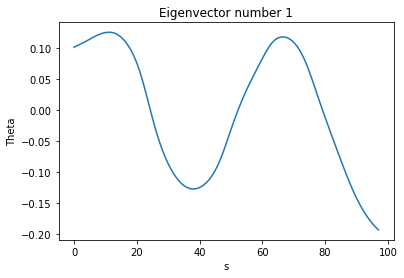

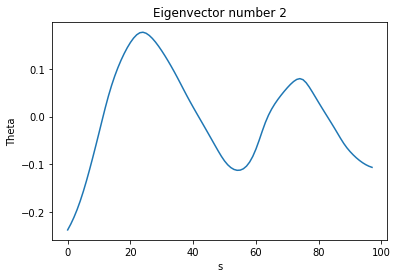

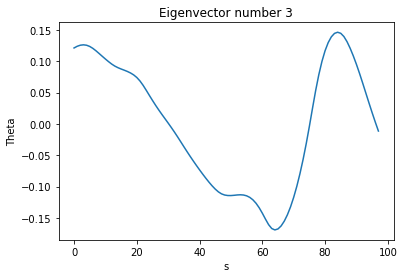

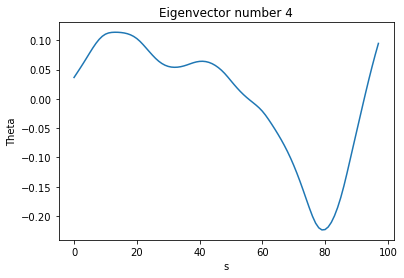

In [160]:
pca = PCA()
pca.fit(matrix_of_thetas)
pca.components_.shape

for i in range(4): # plotting the first 4 eigenvectors
    e = pca.components_[i]
    plt.xlabel("s")
    plt.ylabel("Theta")
    plt.title(f"Eigenvector number {i+1}")
    plt.plot(np.arange(nbr_points - 2), e)
    plt.savefig(f"graphs_ryu/eigen_vector_n_{i+1}.jpg")
    plt.show()
    

# Explained variances along the body

Now we proceed to plot the cumulative variance along the body of the worm explained by considering _d_ dimensions, with _d_ going from 1 to 4. It can be seen that when using 4 principal components, we are able to explain almost all the variance along all the body of the worm.

In [161]:

def get_graph_explained_variances(matrix_of_thetas, filename, invert_xaxis, max_d = 4):
    reconstructed_covariance_matrices = []
    cov = np.cov(matrix_of_thetas.T)
    for d in np.arange(1, max_d + 1):
        pca = PCA(n_components = d)  #building pca
        proj_data = pca.fit_transform(matrix_of_thetas)  #projecting data on new dimenions
        rec_data = pca.inverse_transform(proj_data)  #recunstructing the data
        rec_cov = np.cov(rec_data.T)  
        reconstructed_covariance_matrices.append(rec_cov)
        
    for i in range(len(reconstructed_covariance_matrices)):
        plt.plot(np.diag(reconstructed_covariance_matrices[i]) / np.diag(cov), label = f"d = {i+1}")
        plt.legend()
    
    if invert_xaxis:  # in our case we needed to invert in order to get a graph with the same orientation as in the DBC paper
        plt.gca().invert_xaxis() 
    plt.ylabel("fraction of explained variance")
    plt.xlabel("s")
    plt.title("Fraction of variance captured at each point along the body curve\n")
    if filename != None:
        plt.savefig(f"graphs_ryu/{filename[:-1]}_graph_explained_variances.jpg")
    plt.show()

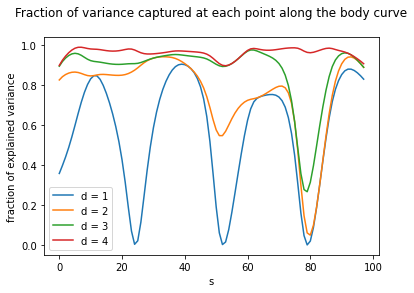

In [162]:
get_graph_explained_variances(matrix_of_thetas = matrix_of_thetas, filename = path, invert_xaxis = False, max_d = 4)

# PCA: first 2 principal components

Finally, we consider the two and three dimenisonal PCA plots.

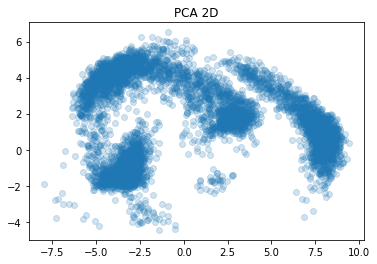

In [163]:
# Using manual pca
plt.scatter(pca_proj[:,0],pca_proj[:,1],alpha=0.2)
plt.title(f"PCA 2D")
plt.savefig(f"graphs_ryu/pca_2d.jpg")

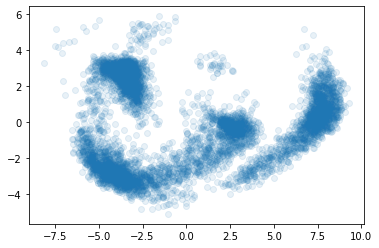

In [164]:
#Using sklearn pca
pca = PCA(n_components=2)
pca.fit(matrix_of_thetas)
X = pca.transform(matrix_of_thetas)
plt.scatter(X[:,0],X[:,1],alpha=0.1)
plt.show()

# PCA: first 3 principal components

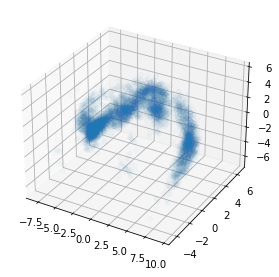

In [165]:
#Using manual pca
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_proj[:, 0],
              pca_proj[:, 1],
              pca_proj[:, 2],
          alpha = 0.02)
plt.show()

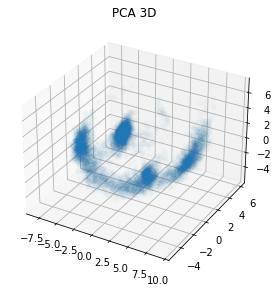

In [166]:
#Using sklearn pca
pca = PCA(n_components=3)
pca.fit(matrix_of_thetas)
X = pca.transform(matrix_of_thetas)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0],
              X[:, 1],
              X[:, 2],
          alpha = 0.02)
plt.title(f"PCA 3D")
plt.savefig(f"graphs_ryu/pca_3d.jpg")